# cat & fish classification 1

In [1]:
# !unzip /content/images.zip -d /content/sample_data/data1/

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [85]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [86]:
img_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_data_path = "data/data1/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

val_data_path = "data/data1/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [87]:
batch_size = 64

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [88]:
class SimpleNet2(nn.Module):
  def __init__(self):
    super(SimpleNet2, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

simplenet = SimpleNet2()
print(simplenet)

SimpleNet2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
   

In [89]:
import torch.optim as optim

optimizer = optim.Adam(simplenet.parameters(), lr=0.0005)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


In [90]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    loss_ = [[], []]
    acc_ = []
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        loss_[0] += [training_loss]
        loss_[1] += [valid_loss]
        acc_ += [num_correct / num_examples]
        print(
            f"Epoch: {epoch}",
            f"Training Loss: {training_loss}",
            f"Validation Loss: {valid_loss}",
            f"Acc: {acc_[-1]}",
            sep=", ",
        )
    return loss_, acc_


In [91]:
if torch.cuda.is_available():
    print("cuda is available")
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

simplenet.to(device)

loss, acc = train(
    simplenet,
    optimizer,
    torch.nn.CrossEntropyLoss(),
    train_data_loader,
    val_data_loader,
    epochs=20,
    device=device
)

cuda is available
Epoch: 1, Training Loss: 0.7515718934206753, Validation Loss: 0.7611640212691833, Acc: 0.17757009345794392
Epoch: 2, Training Loss: 0.629378307118944, Validation Loss: 0.704236226661183, Acc: 0.17757009345794392
Epoch: 3, Training Loss: 0.5395026791258538, Validation Loss: 0.6836084701190485, Acc: 0.7663551401869159
Epoch: 4, Training Loss: 0.47755514304627056, Validation Loss: 0.5033025073113843, Acc: 0.7570093457943925
Epoch: 5, Training Loss: 0.45195583992373417, Validation Loss: 0.5429515526673504, Acc: 0.7289719626168224
Epoch: 6, Training Loss: 0.3867623787910334, Validation Loss: 0.6594189761955047, Acc: 0.6915887850467289
Epoch: 7, Training Loss: 0.37167768634867054, Validation Loss: 0.4076268703581017, Acc: 0.8317757009345794
Epoch: 8, Training Loss: 0.3363047760426546, Validation Loss: 0.46669521844275647, Acc: 0.7570093457943925
Epoch: 9, Training Loss: 0.3115443641345309, Validation Loss: 0.5983060208436485, Acc: 0.6542056074766355
Epoch: 10, Training Loss

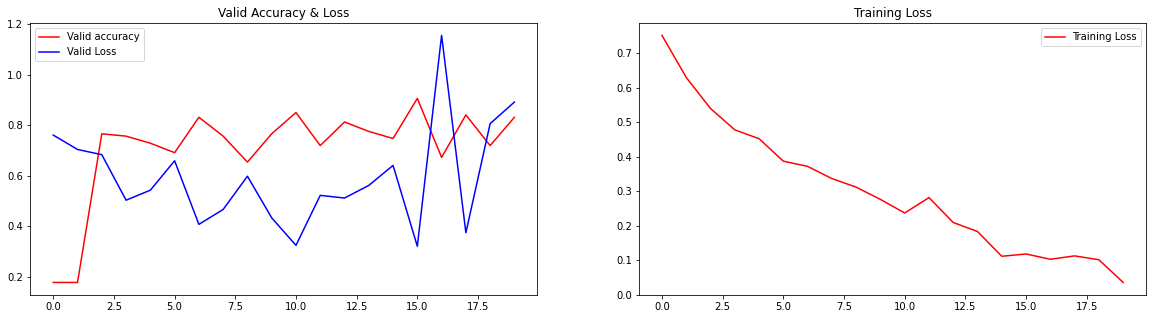

In [92]:
def plot_loss_acc(loss_, acc_):
    epochs = range(len(acc_))
    plt.figure(figsize=(20, 5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Valid Accuracy & Loss')
    plt.plot(epochs, acc_, 'r', label='Valid accuracy')
    plt.plot(epochs, loss_[1], 'b', label='Valid Loss')
    plt.legend()
    
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Training Loss')
    plt.plot(epochs, loss_[0], 'r', label='Training Loss')
    plt.legend()
    plt.show()

# print(loss, acc)
plot_loss_acc(loss, acc)

In [56]:
torch.save(simplenet.state_dict(), "tmp/simplenet")
simplenet = SimpleNet2()
simplenet_state_dict = torch.load("tmp/simplenet")
simplenet.load_state_dict(simplenet_state_dict)

/tmp/ipykernel_2317/3330686652.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simplenet_state_dict = torch.load("tmp/simplenet")


<All keys matched successfully>

In [ ]:
# labels = ['cat','fish']

# img = Image.open("/content/sample_data/data1/val/cat/1041842900_1c5202b05c.jpg")
# img = img_transforms(img).to(device)
# img = torch.unsqueeze(img, 0)

# simplenet.eval()
# prediction = F.softmax(simplenet(img), dim=1)
# prediction = prediction.argmax()
# print(labels[prediction])